This notebook demonstrates integration of functionality from SNT with Python through pyimagej.  
Here's what we will accomplish:
1. Generate a convex hull of the axon terminals within a specific brain region
2. Compare the volume of this convex hull to the volume of the encompasing Allen CCF compartment.
3. Do PCA on the point cloud of the relevant axon terminals.
4. Visualize the results of these operations using Reconstruction Viewer.

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge pyimagej openjdk=8

In [2]:
import os
import imagej
import trimesh
import numpy as np
from collections import defaultdict

In [3]:
# Initialize Fiji with GUI support.
ij = imagej.init('sc.fiji:fiji', headless=False)

from jnius import autoclass, cast

In [4]:
# Import relevant SNT (Java) classes.
# https://morphonets.github.io/SNT/sc/fiji/snt/io/MouseLightLoader.html
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
# https://morphonets.github.io/SNT/sc/fiji/snt/Tree.html
Tree = autoclass('sc.fiji.snt.Tree')
# https://morphonets.github.io/SNT/sc/fiji/snt/util/PointInImage.html
PointInImage = autoclass('sc.fiji.snt.util.PointInImage')
# https://morphonets.github.io/SNT/sc/fiji/snt/analysis/TreeAnalyzer.html
TreeAnalyzer = autoclass('sc.fiji.snt.analysis.TreeAnalyzer')
# https://morphonets.github.io/SNT/sc/fiji/snt/annotation/AllenCompartment.html
AllenCompartment = autoclass('sc.fiji.snt.annotation.AllenCompartment')
# https://morphonets.github.io/SNT/sc/fiji/snt/annotation/AllenUtils.html
AllenUtils = autoclass('sc.fiji.snt.annotation.AllenUtils')
# https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Viewer3D.html
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')

In [5]:
def get_compartment_terminals(tree):
    """Finds the AllenCompartment containing the largest number 
    of axon terminal nodes and returns a collection containing 
    these nodes as well as the id of the relevant AllenCompartment"""
    
    # Use TreeAnalyzer to extract the terminal nodes from the Tree.
    # The returned object is a Java Set containing PointInImage objects.
    # https://docs.oracle.com/javase/7/docs/api/java/util/Set.html
    # https://morphonets.github.io/SNT/sc/fiji/snt/util/PointInImage.html
    tips = TreeAnalyzer(tree).getTips()
    # We will store a list of the endpoints for each target brain region in a dictionary,
    # where the keys are the integer ids of the brain region compartments.
    compartment_dict = defaultdict(list)
    # Use pyimagej to convert the Java collection to the equivalent construct in Python
    # so that we may iterate over it.
    for t in ij.py.from_java(tips):
        # Get the BrainAnnotation object associated with each terminal node.
        # https://morphonets.github.io/SNT/sc/fiji/snt/annotation/BrainAnnotation.html
        # Since this neuron was fetched from the MouseLight database, the annotations are
        # instances of the AllenCompartment Class.
        annotation = t.getAnnotation()
        if annotation is not None:
            compartment_dict[annotation.id()].append(t)
    # Get the compartment ID integer which contains the maximum number of axon terminals.
    max_compartment_id = max(compartment_dict, key= lambda x: len(compartment_dict[x]))
    # Get the associated list of terminals.
    compartment_tips = compartment_dict[max_compartment_id]
    
    return compartment_tips, max_compartment_id

In [6]:
def run():
    
    # Fetch swc from MouseLight database by ID String.
    loader = MouseLightLoader('AA1044')
    if not loader.isDatabaseAvailable():
        print("Could not connect to ML database", "Error")
        return
    if not loader.idExists():
        print("Somewhow the specified id was not found", "Error")
        return
    
    # Extract the axon sub-tree
    tree_axon = loader.getTree("axon")
    axon_terminals, compartment_id = get_compartment_terminals(tree_axon)
    # Use the compartment integer id to construct the AllenCompartment instance.
    compartment = AllenCompartment(compartment_id)
    # To get the convex hull of the terminal nodes using trimesh, 
    # we need to convert the Collection of PointInImage objects
    # to their [x, y, z] coordinate representation as a 2D Python array.
    axon_terminals_python = [[t.getX(), t.getY(), t.getZ()] for t in axon_terminals]
    # Get the convex hull of the tips using trimesh.
    axon_terminals_hull = trimesh.PointCloud(axon_terminals_python).convex_hull
    # We can get the dominant hemi-half of the target compartment using AllenUtils.
    centroid = np.mean(axon_terminals_python, axis=0)
    hemisphere = "left" if AllenUtils.isLeftHemisphere(PointInImage(centroid[0], centroid[1], centroid[2])) else "right"
    # Get the vertices of the OBJMesh which represents the AllenCompartment instance.
    # https://morphonets.github.io/SNT/sc/fiji/snt/viewer/OBJMesh.html
    obj_mesh_vertices = compartment.getMesh().getVertices(hemisphere)
    # Convert to nested Python list as with the axon terminals.
    obj_mesh_vertices_python = [[v.getX(), v.getY(), v.getZ()] for v in ij.py.from_java(obj_mesh_vertices)]
    # Get the convex hull representing the hemi-half compartment.
    obj_mesh_hull = trimesh.PointCloud(obj_mesh_vertices_python).convex_hull
    
    # Now compare the volumes of the convex hulls
    print("Percentage of volume occupied by the convex hull of "
          "the axon terminals with respect to the {} Caudoputamen".format(hemisphere))
    print((axon_terminals_hull.volume / obj_mesh_hull.volume) * 100, "%")
    
    # Now we may begin adding the computed objects to SNT's Viewer3D.
    # Viewer3D has a script-friendly 'add' method which accepts a variety of differnent objects,
    # e.g., Tree, AbstractDrawable, OBJMesh, etc...
    viewer = Viewer3D()
    viewer.add(tree_axon)
    axon_hull = viewer.annotateSurface(ij.py.to_java(axon_terminals), 
                                       "Convex Hull of Axon Terminals within {}".format(compartment.name()))
    axon_hull.setColor("orange")
    # We add the original compartment mesh, which contains both left and right nuclei.
    viewer.add(compartment.getMesh())
        
    # As a bonus, let's estimate the principal components of the covariance on the point cloud given 
    # by the axon terminals and annotate the resulting eigenvectors as line segments.
    # First, subtract the mean from the points.
    points = np.copy(axon_terminals_python)
    points -= centroid
    # Compute the eigenvalues and eigenvectors of the covariance matrix.
    e_values, e_vectors = np.linalg.eig(np.cov(points.transpose()))
    # Construct the line segments using the eigenvectors.
    for i in range(e_vectors.shape[1]):
        # The line segments will originate at the centroid of the terminals.
        end = centroid + ((np.sqrt(e_values[i]) * 10) * e_vectors[:, i])
        line_segment = [PointInImage(centroid[0], centroid[1], centroid[2]), PointInImage(end[0], end[1], end[2])]
        # Viewer3D supports adding annotations of various types, and allows customization of 
        # their visual properties.
        # https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Annotation3D.html
        annot = viewer.annotateLine(ij.py.to_java(line_segment), "component {}".format(i))
        annot.setColor("white", 10)
        annot.setSize(20)
    
    # Finally, we can visualize all our hard work!
    viewer.show()
    # Let's take a snapshot of the Viewer scene
    snapshot_path = os.getcwd() + '/notebook-snapshots/recViewer-snapshot.png'
    viewer.saveSnapshot(snapshot_path)
    # To embed the snapshot in this notebook
    from IPython.display import Image, display
    display(Image(filename=snapshot_path))
    

Percentage of volume occupied by the convex hull of the axon terminals with respect to the right Caudoputamen
3.508223713179358 %


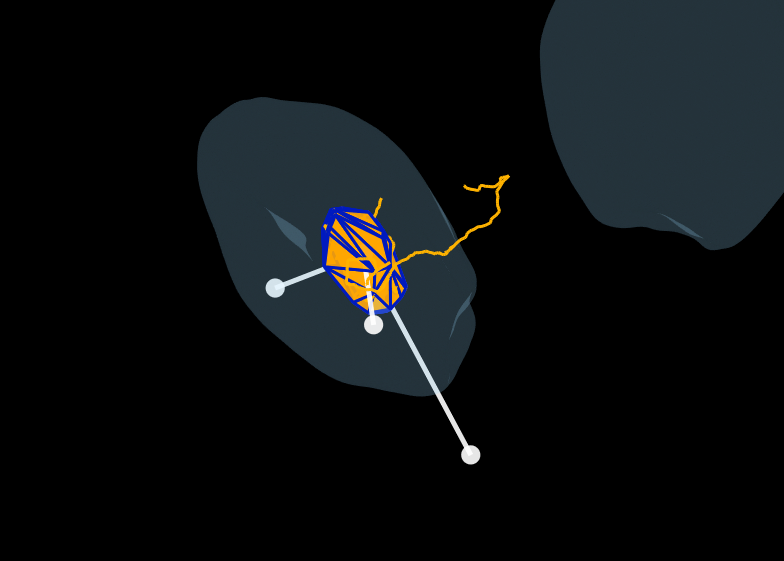

In [7]:
run()